In [3]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import numpy as np

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
base_model_path = './mbart-large-51-mans-raw'

In [5]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [6]:
old_len = len(tokenizer)
old_len

261160

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [7]:
tokenizer.lang_code_to_id['mans_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'mans_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'mans_XX' not in tokenizer._additional_special_tokens:
    tokenizer._additional_special_tokens.append('mans_XX')

In [8]:
import pandas as pd

golden_pairs = pd.read_csv('train.csv')
#golden_pairs.drop(columns=["Unnamed: 0"], inplace=True)
golden_pairs

,ru,mans
0,"Здравствуйте, милые дети!..","Пася ōлэ̄н, я̄тил ня̄врамыт!.."
1,"Здравствуйте, милые дети!..","Пася ōлэ̄н, я̄тил ня̄врамыт!.."
2,"Здравствуйте, взрослые люди!","Пася ōлэ̄н, яныг ма̄хум!"
3,Желаете ли вы [нас] послушать?,Сōль ман хӯнтлаӈкв таӈхегы̄на?
4,Желаете ли вы [на нас] посмотреть?,Сōль ман сунсуӈкв таӈхегы̄н?
...,...,...
79370,В округе много таких домов и они там с народом...,Округувт са̄в тамле кол о̄лы ос та̄н ма̄хум ёт...
79371,"Говорит, учится на медсестру и повара, умеет д...","Ла̄ви, ма̄нь ле̄ккарыг ос тэ̄нут па̄йтнэ хо̄тп..."
79372,"Мы не шумели, хорошо слушали.","Ма̄н о̄с мори ат капыртасув, ёмщакве̄г хӯнтлысув."
79373,"Весной мы хотели поехать в поселок Ушму, погов...","Тӯяй ма̄н Ушма па̄вылн ялуӈкв куссӯв, ма̄ньщит..."


In [9]:
golden_pairs.sample(1, random_state=42)

,ru,mans
36456,"Царь Ирод, не узнав, где найти Младенца, посла...","Ирод хōн ат вāстэ, хōт Ня̄врам хōнтуӈкве, хōнт..."


In [10]:
all_pairs = []
for ru_sent, mans_sent in zip(golden_pairs['ru'], golden_pairs['mans']):
    all_pairs.append((mans_sent, ru_sent))

In [11]:
print(len(all_pairs))

79375


In [12]:
import random

random.choice(all_pairs)

('Лё̄х хосит, э̄ртам тэ̄лы мо̄винт тарм, а̄нас ха̄ртмытсыт, лӯвыт сэ̄ӈкв нэ̄глы; лӯв я̄ласан хотпа ла̄глыл я̄лыгланти, па̄ссал  ра̄ттанти, ва̄ӈныл нё̄рыла̄ӈтэгыт, а̄сирма̄кве э̄ссягве.',
 'По дорогам, будто зиме на смех, обозы потянулись, от лошадей пар валит; извозчики ногами потапывают, рукавицами похлапывают, плечами передёргивают, морозцы похваливают.')

## Training

In [13]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [16]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path).to("cuda")

In [ ]:
#model.cuda();

In [17]:
!nvidia-smi

Sun Sep  8 15:23:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:8C:00.0 Off |                  Off |
| N/A   32C    P0              41W / 250W |   2700MiB / 32768MiB |     51%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### First, update just the new embeddings

In [18]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [19]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [20]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [21]:
tokenizer.src_lang = "ru_RU"
tokenizer.tgt_lang = "mans_XX"

In [22]:
#wandb logging
%pip install wandb -qU 


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [23]:
# Log in to your W&B account
import wandb
import os

# Use wandb-core, temporary for wandb's new backend
wandb.require("core")

wandb.login(key="8c745c35783186f823a53c1d97aeb0c334c92530")

wandb.init(
    # set the wandb project where this run will be logged
    project="ru-mans-translation-mbart_2",
)

# optional: track gradients
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anastmezentseva (naughty-research). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: Tracking run with wandb version 0.17.9
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20240908_152512-uf3e2mrn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run generous-sky-1
wandb: ⭐️ View project at https://wandb.ai/naughty-research/ru-mans-translation-mbart_2
wandb: 🚀 View run at https://wandb.ai/naughty-research/ru-mans-translation-mbart_2/runs/uf3e2mrn


[]

In [24]:
def train_log(loss, step, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=step)
    print('step:', step, 'loss:', np.mean(losses[-report_steps:]))

In [24]:
tokenizer;

In [27]:
model;

In [27]:
import warnings

warnings.filterwarnings("ignore")

In [28]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in range(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer(text_target=[p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256,
                         ).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            train_log(loss=np.mean(losses[-report_steps:]), step=i, epoch=epoch)

EPOCH 0
step: 0 loss: 15.531016141176224
step: 500 loss: 10.29891763973236
step: 1000 loss: 5.502625228881836
step: 1500 loss: 4.112294716596604
step: 2000 loss: 3.698098417520523
step: 2500 loss: 3.4791637187004087
step: 3000 loss: 3.3396338657140734
step: 3500 loss: 3.1878438668251037
step: 4000 loss: 3.0753990488052367
step: 4500 loss: 2.9483542996644974
step: 5000 loss: 2.86131050825119
step: 5500 loss: 2.802218156576157
step: 6000 loss: 2.752146312952042
step: 6500 loss: 2.7245877735614776
step: 7000 loss: 2.610733845472336
step: 7500 loss: 2.5718622086048124
step: 8000 loss: 2.5101892226934432
step: 8500 loss: 2.46728742647171
step: 9000 loss: 2.4316833925247194
step: 9500 loss: 2.404686649799347


Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [29]:
save_model_path = './mbart-large-51-ru-mans-v2'

In [30]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


('./mbart-large-51-ru-mans-v2/tokenizer_config.json',
 './mbart-large-51-ru-mans-v2/special_tokens_map.json',
 './mbart-large-51-ru-mans-v2/sentencepiece.bpe.model',
 './mbart-large-51-ru-mans-v2/added_tokens.json')

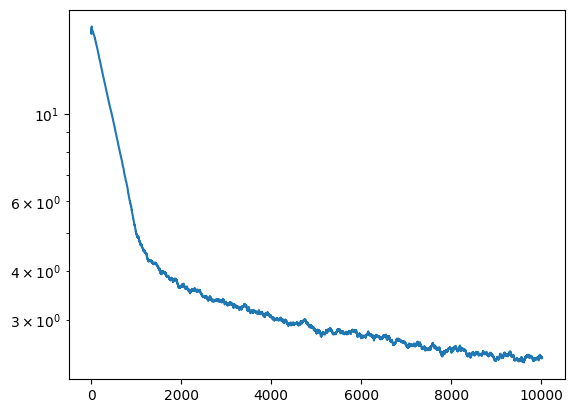

In [31]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [32]:
# %pip install transformers sentencepiece sacrebleu -q

In [33]:
# import torch
# from transformers import MBartForConditionalGeneration, MBart50Tokenizer
# import numpy as np
# import pandas as pd

# import warnings

# warnings.filterwarnings("ignore")


# one_epoch_embds_updated_model_path = './mbart-large-51-ru-mans-v1'
# tokenizer = MBart50Tokenizer.from_pretrained(one_epoch_embds_updated_model_path)
# old_len = len(tokenizer)

# tokenizer.lang_code_to_id['mans_XX'] = old_len-1
# tokenizer.id_to_lang_code[old_len-1] = 'mans_XX'
# tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

# tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
# tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
# if 'mans_XX' not in tokenizer._additional_special_tokens:
#     tokenizer._additional_special_tokens.append('mans_XX')
    
# tokenizer.src_lang = "ru_RU"
# tokenizer.tgt_lang = "mans_XX"


# golden_pairs = pd.read_csv('overall_80K.csv')
# golden_pairs.drop(columns=["Unnamed: 0"], inplace=True)

# all_pairs = []
# for ru_sent, mans_sent in zip(golden_pairs['source'], golden_pairs['target']):
#     all_pairs.append((mans_sent, ru_sent))

In [35]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [36]:
# model = MBartForConditionalGeneration.from_pretrained(one_epoch_embds_updated_model_path).to("cuda")

In [37]:
for p in model.model.shared.parameters():
    print(p.requires_grad)

True


In [38]:
# %pip install wandb -qU 

In [50]:
# # Log in to your W&B account
# import wandb
# import os

# # Use wandb-core, temporary for wandb's new backend
# wandb.require("core")

# wandb.login(key="8c745c35783186f823a53c1d97aeb0c334c92530")

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="ru-mans-translation-mbart-full-finetune-v2",
# )

# # optional: track gradients
# wandb.watch(model)

In [51]:
def train_log(loss, step, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=step)
    print('step:', step, 'loss:', np.mean(losses[-report_steps:]))

In [52]:
loss = None
# optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [53]:
for p in model.parameters():
    p.requires_grad = True

In [54]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [55]:
batch_size = 8 # 8
report_steps = 500 
epochs = 5 #3
losses = []

In [56]:
import random

save_model_path = './mbart-large-51-ru-mans-v2-full-finetune'

Optimizing all parameters takes x1.5 longer than just embeddings (4h): about 6h per epoch. 

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in range(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            train_log(loss=np.mean(losses[-report_steps:]), step=9500 + i, epoch=epoch) #9500 steps was maded previosly
    model.save_pretrained(save_model_path + f"epoch_{epoch}")
    tokenizer.save_pretrained(save_model_path + f"epoch_{epoch}")

EPOCH 0
step: 9500 loss: 1.888309121131897
step: 10000 loss: 2.2700489798784256
step: 10500 loss: 2.200860496878624
step: 11000 loss: 2.149562078356743
step: 11500 loss: 2.1595899056196215
step: 12000 loss: 2.1444624788761137
step: 12500 loss: 2.1138124014139175


The final loss was about 1.01.

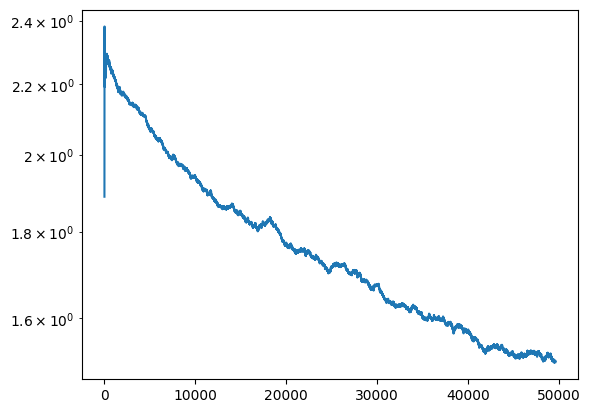

In [62]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(1000).mean().plot();
plt.yscale('log');

In [ ]:
# model.save_pretrained('mbart-large-51-ru-mans-v1-full-finetune-5-epochs')
# tokenizer.save_pretrained('mbart-large-51-ru-mans-v1-full-finetune-3-epochs')

In [20]:
model.eval();

In [70]:
mans, ru = random.choice(all_pairs)
mans, ru

('Юв щалтсӯв, потрамēв, толтыглахтэв, ща̄й аюӈкве ӯнтсӯв. ',
 'Домой зашли, разговариваем, согрелись, стали чай пить. ')

In [71]:
def translate(text, src='ru_RU', trg='mans_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(ru)

'Юв ёхтысыт, потырēв, исумсув, ща̄йаюӈкве патсыт.'

In [74]:
mans, ru = random.choice(all_pairs)
mans, ru

('Тамле яныг рӯпатакапай ты ёмас сымыӈ хо̄тпа Светлана Алексеевна ты ва̄ри.',
 'Такую большую работу выполняет добрая женщина Светлана Алексеевна.')

In [75]:
translate(ru)

'Тамле яныг рӯпата ёмас э̄ква Светлана Алексеевна ва̄ри.'

In [76]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

# Evaluate

In [ ]:
!ls /gd/MyDrive/datasets/nlp/myv_corpus/

dev1000.v1.json			     myv_mono.v1.json  train.v1.json
myv_mono.v1.back_translated.v1.json  test1000.v1.json


In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/dev1000.v1.json', 'r') as f:
    dev = json.load(f)

In [ ]:
dev_target = {k: [er for er, ru in v] for k, v in dev.items()}

In [ ]:
dev_translated = {k: [translate(ru) for er, ru in tqdm(v)] for k, v in dev.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
from sacrebleu import CHRF, BLEU
chrf_calc = CHRF(word_order=2)
bleu_calc = BLEU()

ChrF++ is 50, but BLEU is only 18. 

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                36.45
tales                37.33
constitution         61.46
games                29.37
fiction              25.51
wiki                 50.63
41.821449810361266


In [ ]:
for k in dev:
    s = bleu_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                9.37
tales                13.42
constitution         25.54
games                8.72
fiction              7.39
wiki                 30.55
18.728524159764728
